# Lab03: MLP

---
MSSV: 18120061

Họ và tên: Lê Nhựt Nam

## Import

In [19]:
%matplotlib inline
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle

# ignore warning ...
import warnings
import math
warnings.filterwarnings('ignore')

## Định nghĩa các hàm
**Hàm đọc bộ dữ liệu CIFAR-10**

In [20]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin1')
    return dict
def read_data(containing_dir, num_train_batchs):
    # Read training data
    train_X_batchs = []
    train_Y_batchs = []
    for batch_idx in range(num_train_batchs):
        batch = unpickle(containing_dir + '\\data_batch_' + str(batch_idx + 1))
        train_X_batchs.append(batch['data'])
        train_Y_batchs.append(np.array(batch['labels']).reshape(-1, 1))
    train_X = np.vstack(train_X_batchs)
    train_X = train_X / 255. # Normalize to [0, 1]
    train_X = np.hstack([np.ones((len(train_X), 1)), train_X])
    train_Y = np.vstack(train_Y_batchs)
    
    # Read test data
    batch = unpickle(containing_dir + '\\test_batch')
    test_X = batch['data']
    test_X = test_X / 255. # Normalize to [0, 1]
    test_X = np.hstack([np.ones((len(test_X), 1)), test_X])
    test_Y = np.array(batch['labels']).reshape(-1, 1)
    
    return (train_X, train_Y, test_X, test_Y)

**Hàm tính output và gradient của Neural Net**

Ở đây, ta dùng hàm kích hoạt sigmoid ở các tầng ẩn, và hàm softmax ở tầng cuối.
Ta có:

$$ h=w^TX $$

$$\text{Sigmoid Activation: } z= \sigma \left(h\right)= \dfrac{1}{1+e^{-h}}$$

$$\text{Cross-entrophy loss: } J(w)=-\left({ylog(z)+(1-y)log(1-z)}\right)$$

$$\text{Chain rule: } \dfrac{\partial J(w)}{\partial w}=\dfrac{\partial J(w)}{\partial z} \dfrac{\partial z}{\partial h}\dfrac{\partial h}{\partial w}  $$

$$\dfrac{\partial J(w)}{\partial z}=-\left(\dfrac{y}{z}-\dfrac{1-y}{1-z}\right)=\dfrac{z-y}{z(1-z)}$$

$$\dfrac{\partial z}{\partial h}=z(1-z)$$

$$\dfrac{\partial h}{\partial w}=X$$

$$\dfrac{\partial J(w)}{\partial w}=X^T(z-y)$$

**Hàm cost và gradient tầng sigmoid:**
$$J(w)=\dfrac{1}{N} \sum_{n=1}^N-\left({ylog(z)+(1-y)log(1-z)}\right)  $$
$$\text{Gradient: } \dfrac{\partial J(w)}{\partial w}=\dfrac{1}{N}X^T(z-y)$$  

Hàm softmax (C là số lớp): 
$$h(z_i)=\dfrac{e^{z_i}}{\sum_{j=1}^{C}e^{z_j}}$$
**Hàm cost tầng softmax lúc này là:**
$$J(w)=\dfrac{1}{N} \sum_{n=1}^N \sum_{k=1}^K -(y_n)_k log \left(h(x_n)_k\right)  $$

Sử dụng kỹ thuật one-hot-encoding mã hóa tập label y, ta có:
 $$\text{với } (y_n)_k=    \begin{align}
        \begin{cases}
             0 \text { nếu } y_n\neq k\\
             1 \text { nếu } y_n= k\\
        \end{cases}
    \end{align} $$
lúc này số lớp sẽ là 2 hay C=2:

$$h(z_1)=\dfrac{e^{z_1}}{\sum_{j=1}^{2}e^{z_j}}$$

$$h(z_1)=\dfrac{e^{z_1}}{e^{z_1}+e^{z_2}}$$

$$h(z_1)=\dfrac{1}{1+e^{z_2-z_1}}$$

=> Đây chính là hàm sigmoid. Hơn nữa mặc dù có 2 output softmax vẫn có thể rút gọn thành 1 output vì tổng 2 outputs luôn bằng 1

**Do đó hàm cost của tầng softmax và tầng sigmoid là tương tự nhau** 

**=> Gradient của tầng softmax cũng tương tự của tầng sigmoid**

In [21]:
# Element x
def sigmoid(x):
    '''
    Computes sigmoid function for each element of array S.
    '''
    return 1 / (1 + np.exp(-x))


# As = ?
# Ws = 
# md_X = mini batch X
# delta = ?
# i = layer i th
def gradient_sigmoid(As, Ws ,mb_X,delta, i):
    '''
    Computes gradient vector for sigmoid layer.
    '''
    As[i] = np.hstack([np.ones((len(mb_X), 1)), sigmoid(np.dot(As[i - 1], Ws[i - 1]))])
    return delta, grad

# Array S
def softmax(S):
    '''
    Computes softmax function for each row of array S.
    '''
    A = np.exp(S)
    A /=A.sum(axis=1, keepdims=True)
    return A

# 
# minibach x = mb_x
# minibach y = mb_y
def gradient_softmax(As,mb_X,mb_Y):
    '''
    Computes gradient vector for softmaz layer
    '''
    delta = (As[-1] - mb_Y) / len(mb_Y)
    grad = np.dot(As[-2].T, delta)
    return delta, grad

# weight matrix shape = Ws
def compute_nnet_outputs(Ws, X, need_all_layer_outputs):
    '''
    Computes the outputs of Neural Net by forward propagating X through the net.
    '''
    As = [X]
    for ws in Ws:
        As.append(np.zeros(shape = (len(X), ws.shape[1])))
    
    for i in range(1, len(As) - 1):
        As[i] = np.hstack([np.ones((len(X), 1)), sigmoid(np.dot(As[i - 1], Ws[i - 1]))])
    As[-1] = softmax(np.dot(As[-2], Ws[-1]))
    A = As[-1]
    if need_all_layer_outputs:
        return As
    else:
        return A

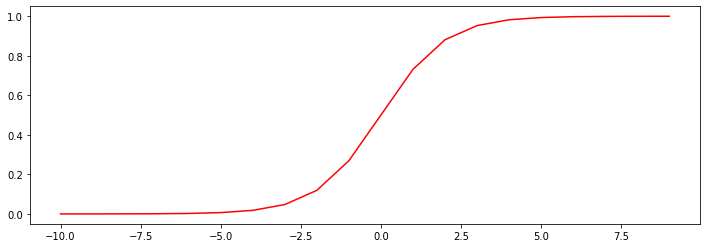

In [22]:
nums = np.arange(-10, 10, step=1)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(nums, sigmoid(nums), 'r')

**Các hàm khởi tạo tham số**

In [23]:

def compute_layer_sizes(X, Y, hid_layer_sizes):
    num_classes = len(np.unique(Y)) # Num classes
    layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [num_classes]
    print('Layer Sizes: ',layer_sizes)
    return layer_sizes


def one_hot_encoding(Y, num_classes):
    num_classes = len(np.unique(Y)) # Num classes
    one_hot_Y = np.zeros((len(Y), num_classes))
    one_hot_Y[np.arange(len(Y)), Y.reshape(-1)] = 1
    return one_hot_Y


def init_weight_matrix(X,Y,layer_sizes):
    #fix random for same result when init weight matrix
    np.random.seed(0) 
    Ws = np.array([np.random.randn(layer_sizes[i]+1 , layer_sizes[i + 1]) / np.sqrt(layer_sizes[i]+1) 
          for i in range(len(layer_sizes) - 1)]) # Init Ws
    print('Weight matrix shape: ',Ws[0].shape,Ws[1].shape)
    return Ws




**Hàm huấn luyện Neural net**

In [24]:

def updateWeights(Ws,As,mb_X, mb_Y,  learning_rate):
    #update weights for softmax layer
    delta, grad = gradient_softmax(As, mb_X=mb_X, mb_Y=mb_Y)
    Ws[-1] = Ws[-1] - (learning_rate * grad) - (2 * learning_rate * Ws[-1])
    
    #update weights for hidden layer
    for i in range(2, len(Ws) + 1):
        delta = delta.dot(Ws[-i + 1].T[:, 1:]) * As[-i][:, 1:] * (1 - As[-i][:, 1:])
        grad = np.dot(As[-i - 1].T, delta)
        Ws[-i] = Ws[-i] - (learning_rate * grad) - (2 * learning_rate * Ws[-i])
    return Ws

def train_nnet(X, Y, hid_layer_sizes, mb_size, learning_rate, max_epoch):
    
    #get layer sizes:
    layer_sizes = compute_layer_sizes(X, Y, hid_layer_sizes)

    
    # Prepare for training
    Ws=init_weight_matrix(X,Y,layer_sizes)
    one_hot_Y=one_hot_encoding(Y,layer_sizes[-1])
    
    costs = [] # To save costs during training
    errs = [] # To save mean binary errors during training
    N = len(X) # Num training examples
    rnd_idxs = list(range(N)) # Random indexes    
    
    # Train
    for epoch in list(range(max_epoch)):
        #shuffle index
        np.random.shuffle(rnd_idxs)
        for start_idx in list(range(0, N, mb_size)):
            # Get minibach
            mb_X = X[rnd_idxs[start_idx:start_idx+mb_size]]
            mb_Y = one_hot_Y[rnd_idxs[start_idx:start_idx+mb_size]]
            
            # Forward-prop
            As = compute_nnet_outputs(Ws, mb_X, True)
            
            # Back-prop; on the way, compute each layer's gradient and update its W
            Ws=updateWeights(Ws,As,mb_X,mb_Y,learning_rate)   

        
        # Compute training info, save it, and print it
        A = compute_nnet_outputs(Ws, X, False)
        cost = np.mean(-np.sum(one_hot_Y * np.log(A), axis=1))
        err = np.mean(np.argmax(A, axis=1) != Y.squeeze()) * 100
        costs.append(cost)
        errs.append(err)
        print ('Epoch %d, cost %.3f, err %.3f%%' %(epoch, cost, err))
            
    return Ws, costs, errs

## Chạy

**1.** Đọc dữ liệu (cần đặt thư mục chứa dữ liệu `cifar-10-batches-py` vào cùng thư mục chứa file notebook này)

In [25]:
num_train_batchs = 3 
train_X, train_Y, test_X, test_Y = read_data('cifar-10-batches-py', num_train_batchs)
print ('train_X.shape = %s, train_Y.shape = %s' %(train_X.shape, train_Y.shape))
print ('test_X.shape  = %s, test_Y.shape  = %s' %(test_X.shape, test_Y.shape))

train_X.shape = (30000, 3073), train_Y.shape = (30000, 1)
test_X.shape  = (10000, 3073), test_Y.shape  = (10000, 1)


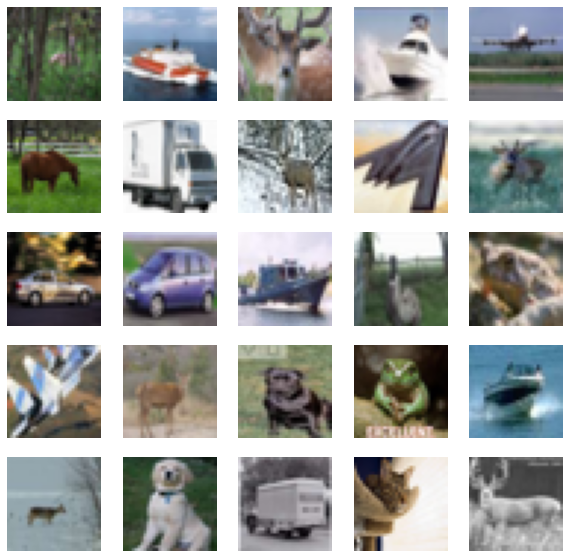

In [26]:
f = open('cifar-10-batches-py/data_batch_1', 'rb')
datadict = cPickle.load(f,encoding='latin1')
f.close()
X = datadict["data"] 
Y = datadict['labels']
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y = np.array(Y)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(10,10))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])

**2.** Để thấy được sự ảnh hưởng của số lượng nơ-ron ẩn, ta sẽ lần lượt huấn luyện Neural Net với `hid_layer_sizes = [50]`, `[100]`, và `[200]` (cố định `mb_size = 32`, `learning_rate = 0.01`, `max_epoch = 200`)

In [27]:
W_0, costs_0, errs_0 = train_nnet(train_X, train_Y, [50], 32, 0.01, 200)

Layer Sizes:  [3072, 50, 10]
Weight matrix shape:  (3073, 50) (51, 10)
Epoch 0, cost 2.303, err 90.057%
Epoch 1, cost 2.303, err 90.090%
Epoch 2, cost 2.303, err 89.973%
Epoch 3, cost 2.303, err 90.057%
Epoch 4, cost 2.303, err 89.860%
Epoch 5, cost 2.303, err 89.977%
Epoch 6, cost 2.303, err 89.977%
Epoch 7, cost 2.303, err 90.003%
Epoch 8, cost 2.303, err 90.017%
Epoch 9, cost 2.303, err 90.057%
Epoch 10, cost 2.303, err 90.057%
Epoch 11, cost 2.303, err 89.977%
Epoch 12, cost 2.303, err 89.977%
Epoch 13, cost 2.303, err 89.923%
Epoch 14, cost 2.303, err 89.973%
Epoch 15, cost 2.303, err 89.973%
Epoch 16, cost 2.303, err 89.923%
Epoch 17, cost 2.303, err 90.003%
Epoch 18, cost 2.303, err 89.860%
Epoch 19, cost 2.303, err 89.973%
Epoch 20, cost 2.303, err 89.947%
Epoch 21, cost 2.303, err 89.947%
Epoch 22, cost 2.303, err 90.017%
Epoch 23, cost 2.303, err 89.860%
Epoch 24, cost 2.303, err 89.947%
Epoch 25, cost 2.303, err 90.003%
Epoch 26, cost 2.303, err 90.057%
Epoch 27, cost 2.303,

In [28]:
W_1, costs_1, errs_1 = train_nnet(train_X, train_Y, [100], 32, 0.01, 200)

Layer Sizes:  [3072, 100, 10]
Weight matrix shape:  (3073, 100) (101, 10)
Epoch 0, cost 2.304, err 90.057%
Epoch 1, cost 2.304, err 90.090%
Epoch 2, cost 2.303, err 90.057%
Epoch 3, cost 2.305, err 89.860%
Epoch 4, cost 2.303, err 89.973%
Epoch 5, cost 2.303, err 89.947%
Epoch 6, cost 2.304, err 89.860%
Epoch 7, cost 2.304, err 90.090%
Epoch 8, cost 2.304, err 89.923%
Epoch 9, cost 2.304, err 89.860%
Epoch 10, cost 2.304, err 90.003%
Epoch 11, cost 2.303, err 89.923%
Epoch 12, cost 2.304, err 89.947%
Epoch 13, cost 2.304, err 90.017%
Epoch 14, cost 2.305, err 90.090%
Epoch 15, cost 2.303, err 90.090%
Epoch 16, cost 2.304, err 89.923%
Epoch 17, cost 2.304, err 90.153%
Epoch 18, cost 2.303, err 90.057%
Epoch 19, cost 2.303, err 89.860%
Epoch 20, cost 2.304, err 90.003%
Epoch 21, cost 2.304, err 90.003%
Epoch 22, cost 2.304, err 90.003%
Epoch 23, cost 2.304, err 90.003%
Epoch 24, cost 2.304, err 90.003%
Epoch 25, cost 2.304, err 90.003%
Epoch 26, cost 2.303, err 89.923%
Epoch 27, cost 2.3

In [29]:
W_2, costs_2, errs_2 = train_nnet(train_X, train_Y, [200], 32, 0.01, 200)

Layer Sizes:  [3072, 200, 10]
Weight matrix shape:  (3073, 200) (201, 10)
Epoch 0, cost 2.306, err 90.153%
Epoch 1, cost 2.306, err 89.860%
Epoch 2, cost 2.307, err 89.860%
Epoch 3, cost 2.304, err 89.947%
Epoch 4, cost 2.307, err 90.153%
Epoch 5, cost 2.306, err 89.947%
Epoch 6, cost 2.304, err 89.973%
Epoch 7, cost 2.304, err 89.973%
Epoch 8, cost 2.309, err 90.090%
Epoch 9, cost 2.305, err 89.860%
Epoch 10, cost 2.304, err 90.153%
Epoch 11, cost 2.306, err 90.057%
Epoch 12, cost 2.305, err 90.017%
Epoch 13, cost 2.304, err 89.923%
Epoch 14, cost 2.304, err 89.923%
Epoch 15, cost 2.305, err 89.973%
Epoch 16, cost 2.306, err 89.947%
Epoch 17, cost 2.306, err 89.947%
Epoch 18, cost 2.305, err 90.090%
Epoch 19, cost 2.305, err 89.947%
Epoch 20, cost 2.306, err 89.860%
Epoch 21, cost 2.304, err 90.003%
Epoch 22, cost 2.308, err 89.973%
Epoch 23, cost 2.307, err 89.860%
Epoch 24, cost 2.305, err 89.973%
Epoch 25, cost 2.304, err 90.090%
Epoch 26, cost 2.304, err 89.977%
Epoch 27, cost 2.3

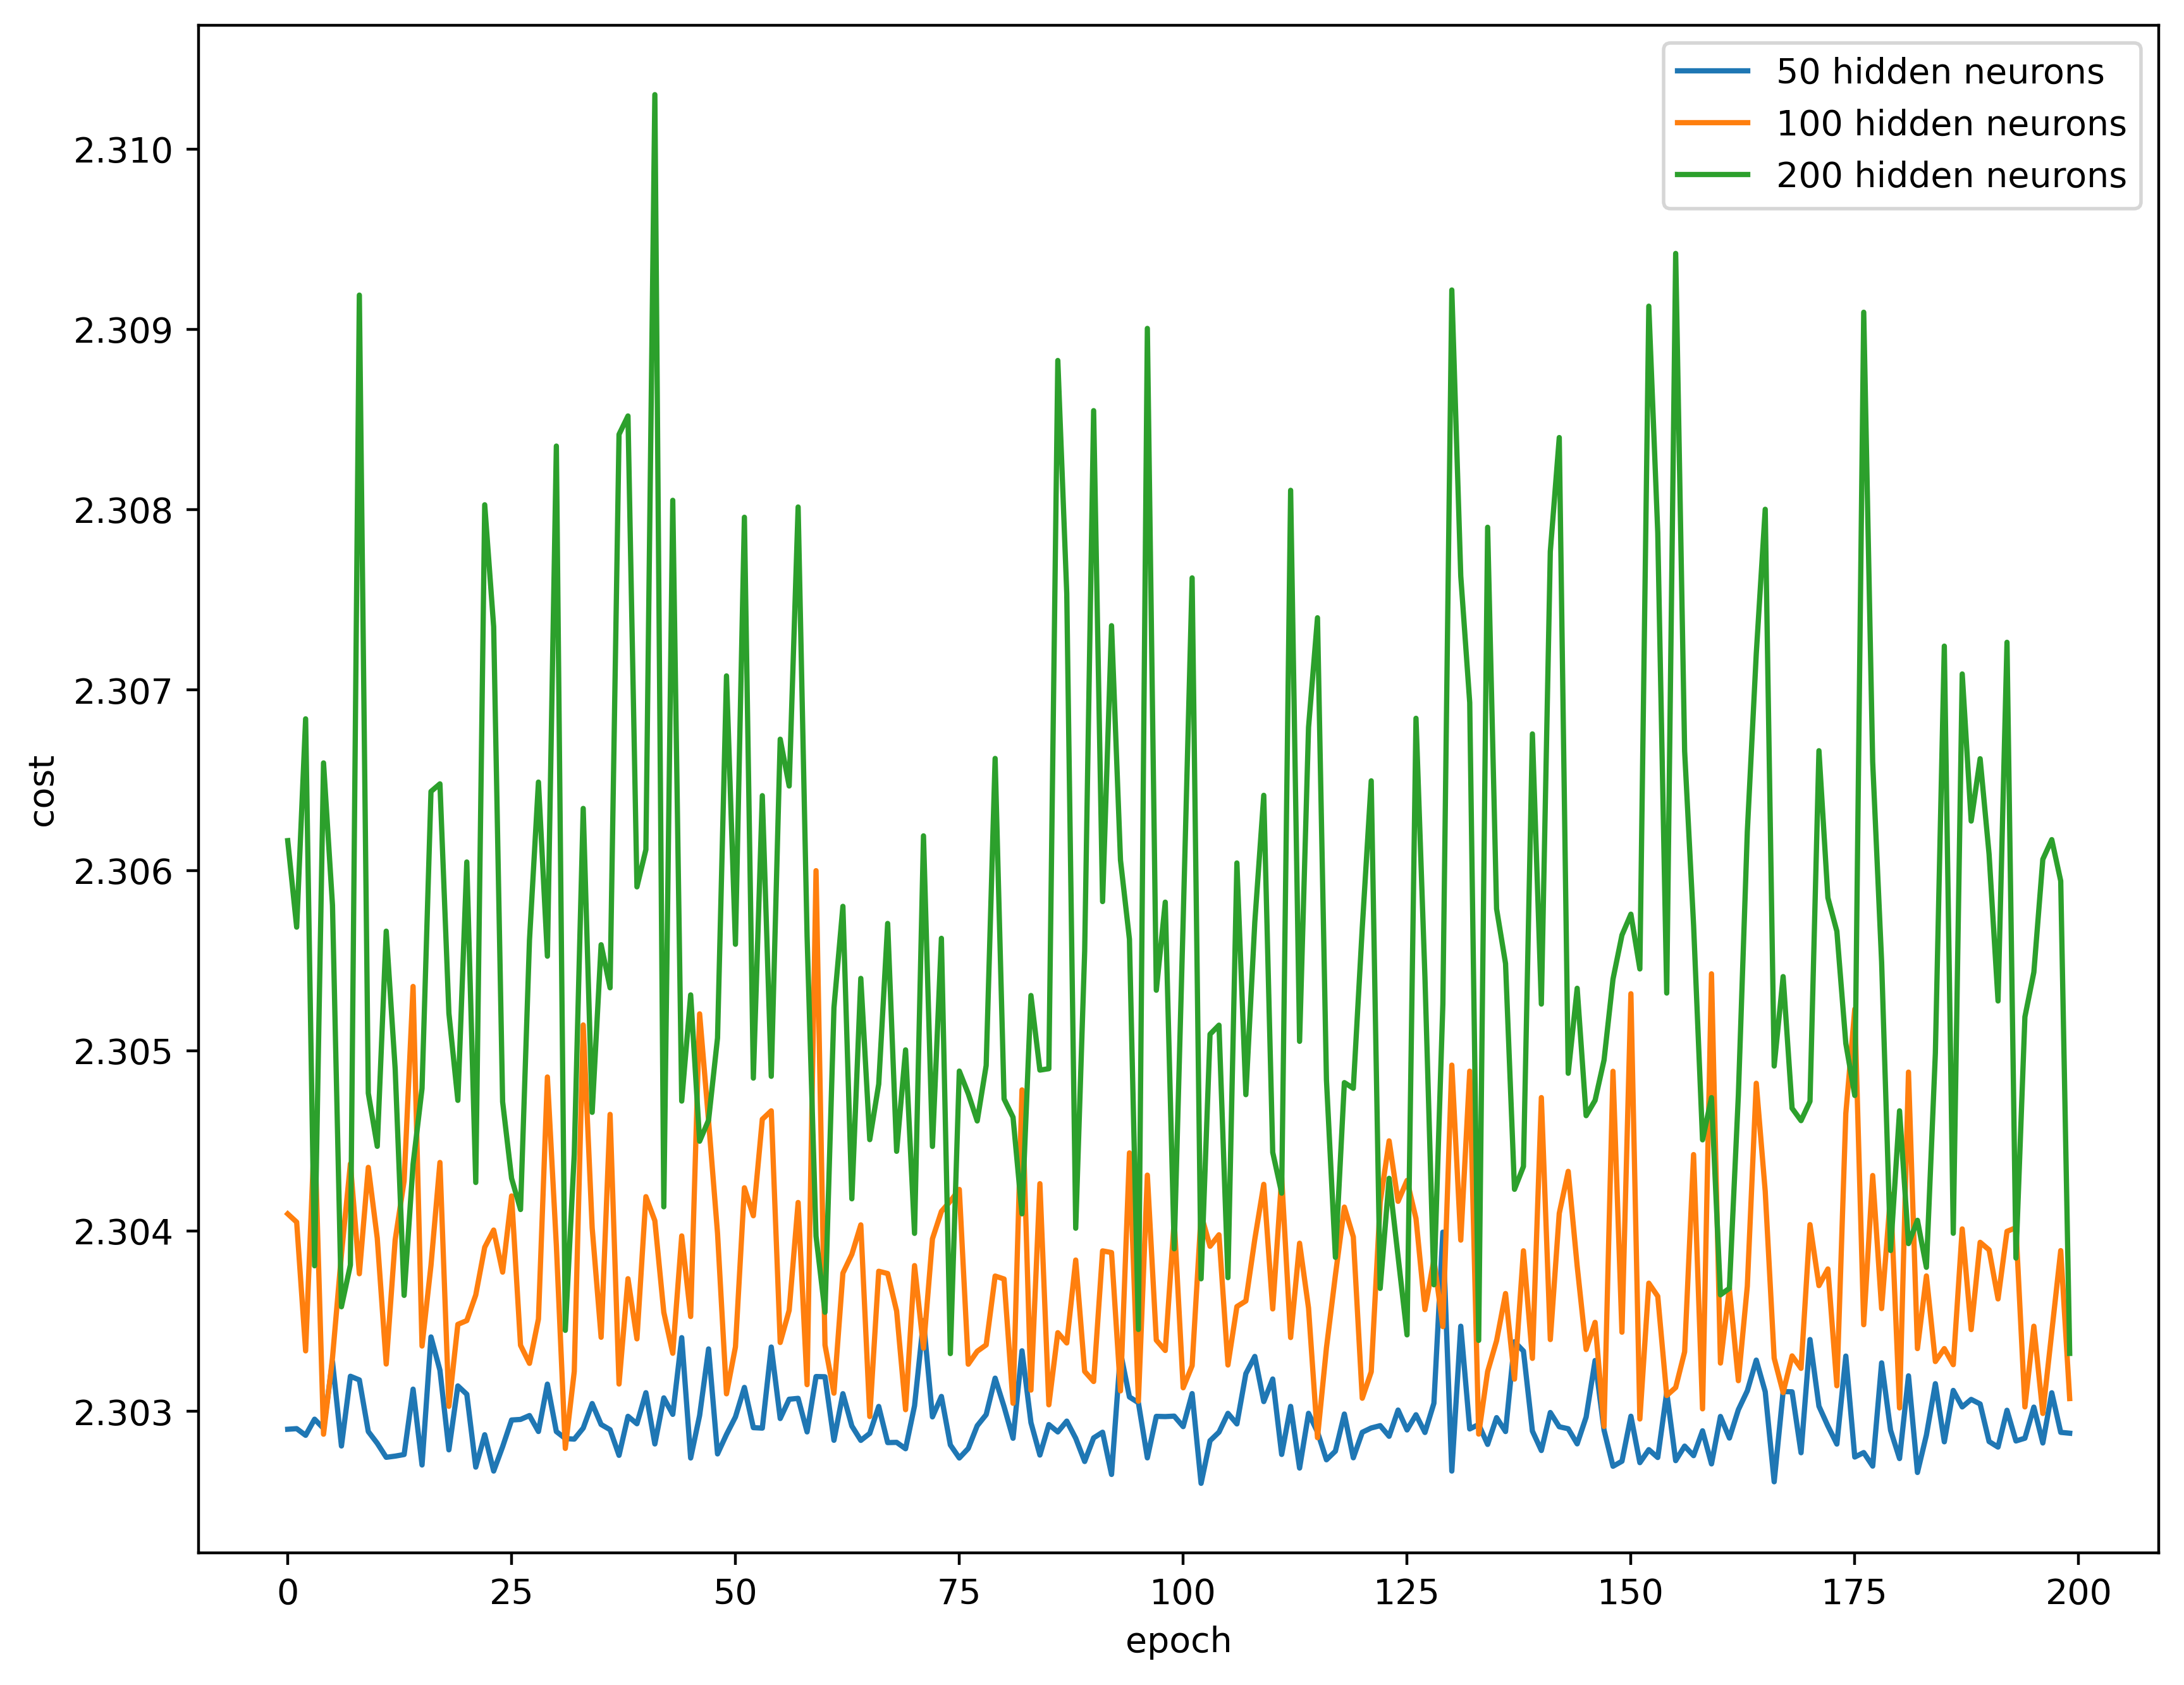

In [30]:
# Visualize results
epochs = np.arange(len(costs_0))
plt.figure(figsize=(10,8),dpi=400)
plt.plot(epochs, costs_0, label='50 hidden neurons')
plt.plot(epochs, costs_1, label='100 hidden neurons')
plt.plot(epochs, costs_2, label='200 hidden neurons')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend(loc='best')
plt.savefig('figure_1.png')

Đánh giá mô  hình